<a href="https://colab.research.google.com/github/ndvinh98/Phone-Recommendation-System/blob/master/Training/Train_new_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Preprocessing***

### **Mount drive & install lib**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s /content/drive/'My Drive'/Sentiment_Classification

In [ ]:
!pip install underthesea
!pip install unidecode
!pip install scikit-learn==0.23.1
!pip install keras==2.2.5
!pip install TensorFlow==1.14

### **import lib**

In [ ]:
import pandas as pd
import glob
import seaborn as sns
import numpy as np
import string
from string import digits, punctuation
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization, SpatialDropout1D
from keras.optimizers import RMSprop,Adam
from keras.models import Sequential
from keras.backend import clear_session
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from underthesea import word_tokenize
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import joblib
import nltk

### **Import data into Pandas**

***remove noise on negaitive reviews***

In [ ]:
df_neg= pd.read_csv('/content/Sentiment_Classification/data/negativeReviews1.csv',sep=',',encoding='utf-8',error_bad_lines=False,index_col=None)
df_neg = df_neg.drop(df_neg[(df_neg.STAR != '1') & (df_neg.STAR != '2') & (df_neg.STAR != '3')].index)
df_neg['LABEL']=0
df_neg.head(5)


b'Skipping line 158: expected 2 fields, saw 4\nSkipping line 181: expected 2 fields, saw 17\nSkipping line 601: expected 2 fields, saw 3\nSkipping line 975: expected 2 fields, saw 3\nSkipping line 1324: expected 2 fields, saw 4\nSkipping line 1326: expected 2 fields, saw 5\nSkipping line 1865: expected 2 fields, saw 3\nSkipping line 1929: expected 2 fields, saw 13\nSkipping line 1989: expected 2 fields, saw 3\nSkipping line 2538: expected 2 fields, saw 3\nSkipping line 2710: expected 2 fields, saw 8\nSkipping line 2903: expected 2 fields, saw 3\nSkipping line 2998: expected 2 fields, saw 3\nSkipping line 3348: expected 2 fields, saw 4\nSkipping line 3621: expected 2 fields, saw 5\nSkipping line 3781: expected 2 fields, saw 9\nSkipping line 3982: expected 2 fields, saw 4\nSkipping line 4917: expected 2 fields, saw 5\nSkipping line 4918: expected 2 fields, saw 6\nSkipping line 4924: expected 2 fields, saw 24\nSkipping line 4959: expected 2 fields, saw 7\n'


,CONTENT,STAR,LABEL
0,Vừa dùng được 3 ngày. Nói chung là khá thất vọ...,3,0
1,Nói tóm lại là xiaomi dạo này dùng chán camera...,1,0
2,Giá con này hơi cao nếu giá này nên chọn s10 l...,1,0
3,"toàn chip đời thấp, chip 865 k thấy bán, giá v...",2,0
4,"Máy dùng ok, mình dùng được có 13 ngày máy lỗi...",3,0


In [ ]:
df_neg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5071 entries, 0 to 5083
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   CONTENT  5071 non-null   object
 1   STAR     5071 non-null   object
 2   LABEL    5071 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 158.5+ KB


***remove noise on positive reviews***

In [ ]:
df_pos= pd.read_csv('/content/Sentiment_Classification/data/positiveReviews1.csv',sep=',',encoding='utf-8',error_bad_lines=False,index_col=None)
df_pos = df_pos.drop(df_pos[(df_pos.STAR != '4') & (df_pos.STAR != '5')].index)
df_pos['LABEL']=1
df_pos.head(5)


b'Skipping line 700: expected 2 fields, saw 3\nSkipping line 1208: expected 2 fields, saw 3\nSkipping line 1478: expected 2 fields, saw 19\nSkipping line 1480: expected 2 fields, saw 9\nSkipping line 1593: expected 2 fields, saw 5\nSkipping line 1692: expected 2 fields, saw 3\nSkipping line 1964: expected 2 fields, saw 4\nSkipping line 2494: expected 2 fields, saw 3\nSkipping line 2658: expected 2 fields, saw 6\nSkipping line 2659: expected 2 fields, saw 4\nSkipping line 2660: expected 2 fields, saw 13\nSkipping line 3229: expected 2 fields, saw 3\nSkipping line 3423: expected 2 fields, saw 3\nSkipping line 3643: expected 2 fields, saw 5\nSkipping line 4212: expected 2 fields, saw 3\nSkipping line 4501: expected 2 fields, saw 8\nSkipping line 4502: expected 2 fields, saw 4\nSkipping line 5786: expected 2 fields, saw 4\nSkipping line 6156: expected 2 fields, saw 10\nSkipping line 6887: expected 2 fields, saw 4\nSkipping line 6895: expected 2 fields, saw 5\nSkipping line 7623: expected 2

,CONTENT,STAR,LABEL
0,"99% ok. chỉ có Wifi là nó bắt hơi yếu, lướt we...",4,1
1,"camera quá tuyệt vời k có chỗ nào chê, còn dùn...",5,1
2,Nhận hàng xài rất ok. Cầm máy rất đầm tay. Chụ...,5,1
3,Chị bán hàng nhiệt tình xinh gái. khi chuyển c...,5,1
4,Đã nhận máy.cảm nhận rất tốt mà phân vân tí là...,4,1


In [ ]:
df_pos=df_pos.loc[0:5500,:]
#df_pos.groupby('STAR').count()
df_pos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5474 entries, 0 to 5500
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   CONTENT  5474 non-null   object
 1   STAR     5474 non-null   object
 2   LABEL    5474 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 171.1+ KB


***combine positive reviews & negative reviews then shuffle***

In [ ]:
df = pd.concat([df_pos,df_neg], axis=0, ignore_index=True)
df = df.sample(frac=1, axis=1).sample(frac=1).reset_index(drop=True)

In [ ]:
df.head(10)

,LABEL,STAR,CONTENT
0,0,1,"Đt bắt wfi vs 4g yếu quá, cảm ứng nhiều lúc k ..."
1,1,5,"Camera siêu đẹp,pin sài lâu,hút wifi tốt,nhân ..."
2,0,2,"Mới mua Pin tụt nhanh, cấu hình yếu, ở những n..."
3,1,5,Mới nhận máy hồi sáng. Máy sử dụng mượt mà. Ch...
4,0,1,Mua máy hồi tháng 9 2019.về máy nóng+mồ hôi ha...
5,0,3,"Nhận máy hqa, thấy các bạn nói pin trâu, nhưng..."
6,0,1,"Mua con máy a50, pin lởm ra. Ko dùng gì để 1 đ..."
7,1,4,"Với tôi, iPhone 7-32G là đủ xài . Chất lượng t..."
8,0,3,"Máy lúc đầu mua về chơi game liên quân mượt, c..."
9,1,5,Sau khi trải nghiệm sản phẩm mình thấy máy đáp...


### **Data visualization**

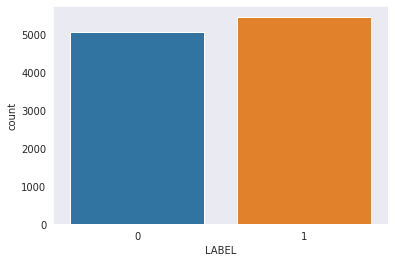

In [ ]:
sns.set_style("dark")
sns.countplot(df.LABEL)

**See how comment look like**

In [ ]:
for i,content in enumerate (df['CONTENT'], 1):
    if i > 20:
        break
    else:
        print('\n',i, content)


 1 Đt bắt wfi vs 4g yếu quá, cảm ứng nhiều lúc k nhận vân tay thua con dt j4 của mình mới mua băt sống khoẻ hơn a50

 2 Camera siêu đẹp,pin sài lâu,hút wifi tốt,nhân viên nhiệt tình, rất hài lòngggggg

 3 Mới mua Pin tụt nhanh, cấu hình yếu, ở những nơi sóng yếu bắt sóng kém...đóng ứng dụng đi ngủ vẫn tụt mất 5% pin
Trong tầm giá vẫn con khác tốt hơn

 4 Mới nhận máy hồi sáng. Máy sử dụng mượt mà. Chưa phát sinh lỗi gì. Camera chụp ảnh đẹp

 5 Mua máy hồi tháng 9 2019.về máy nóng+mồ hôi hay hơi nước trên màn là bị loạn cảm ứng đi bảo hành 1 lần về vẫn như vậy(chán).đều là sim viettel 4G.mà lắp mayd oppo lươt wep chơi game mượt k giật lác.lắp vô samsung A50 không có sóng chứ còn chưa nói đến 4G.có 4G chơi game thì giật mạng yếu thôi rồi.cảm ứng vân tay từ khi mua về không sử dụng đk luôn.lần đầu sử dụng samsung mà thất vọng quá.sẽ không bao giờ mua samsung nữa...

 6 Nhận máy hqa, thấy các bạn nói pin trâu, nhưng mình thấy máy của mình thì pin yếu quá, mọi thứ khác thì ok

 7 Mua con m

### **Text cleansing**

In [ ]:
def normalize_text(text):
    #Remove extended characters: ex: đẹppppppp
    text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)

    # lower text
    text = text.lower()

    #Standardize Vietnamese, handle emoj, standardize English
    replace_list = {
        'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
        'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
        'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
        'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
        'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
        #Quy các icon về 2 loại emoj: Tích cực hoặc tiêu cực
        "👹": "nagative", "👻": "positive", "💃": "positive",'🤙': ' positive ', '👍': ' positive ',
        "💄": "positive", "💎": "positive", "💩": "positive","😕": "nagative", "😱": "nagative", "😸": "positive",
        "😾": "nagative", "🚫": "nagative",  "🤬": "nagative","🧚": "positive", "🧡": "positive",'🐶':' positive ',
        '👎': ' nagative ', '😣': ' nagative ','✨': ' positive ', '❣': ' positive ','☀': ' positive ',
        '♥': ' positive ', '🤩': ' positive ', 'like': ' positive ', '💌': ' positive ',
        '🤣': ' positive ', '🖤': ' positive ', '🤤': ' positive ', ':(': ' nagative ', '😢': ' nagative ',
        '❤': ' positive ', '😍': ' positive ', '😘': ' positive ', '😪': ' nagative ', '😊': ' positive ',
        '?': ' ? ', '😁': ' positive ', '💖': ' positive ', '😟': ' nagative ', '😭': ' nagative ',
        '💯': ' positive ', '💗': ' positive ', '♡': ' positive ', '💜': ' positive ', '🤗': ' positive ',
        '^^': ' positive ', '😨': ' nagative ', '☺': ' positive ', '💋': ' positive ', '👌': ' positive ',
        '😖': ' nagative ', '😀': ' positive ', ':((': ' nagative ', '😡': ' nagative ', '😠': ' nagative ',
        '😒': ' nagative ', '🙂': ' positive ', '😏': ' nagative ', '😝': ' positive ', '😄': ' positive ',
        '😙': ' positive ', '😤': ' nagative ', '😎': ' positive ', '😆': ' positive ', '💚': ' positive ',
        '✌': ' positive ', '💕': ' positive ', '😞': ' nagative ', '😓': ' nagative ', '️🆗️': ' positive ',
        '😉': ' positive ', '😂': ' positive ', ':v': '  positive ', '=))': '  positive ', '😋': ' positive ',
        '💓': ' positive ', '😐': ' nagative ', ':3': ' positive ', '😫': ' nagative ', '😥': ' nagative ',
        '😃': ' positive ', '😬': ' 😬 ', '😌': ' 😌 ', '💛': ' positive ', '🤝': ' positive ', '🎈': ' positive ',
        '😗': ' positive ', '🤔': ' nagative ', '😑': ' nagative ', '🔥': ' nagative ', '🙏': ' nagative ',
        '🆗': ' positive ', '😻': ' positive ', '💙': ' positive ', '💟': ' positive ',
        '😚': ' positive ', '❌': ' nagative ', '👏': ' positive ', ';)': ' positive ', '<3': ' positive ',
        '🌝': ' positive ',  '🌷': ' positive ', '🌸': ' positive ', '🌺': ' positive ',
        '🌼': ' positive ', '🍓': ' positive ', '🐅': ' positive ', '🐾': ' positive ', '👉': ' positive ',
        '💐': ' positive ', '💞': ' positive ', '💥': ' positive ', '💪': ' positive ',
        '💰': ' positive ',  '😇': ' positive ', '😛': ' positive ', '😜': ' positive ',
        '🙃': ' positive ', '🤑': ' positive ', '🤪': ' positive ','☹': ' nagative ',  '💀': ' nagative ',
        '😔': ' nagative ', '😧': ' nagative ', '😩': ' nagative ', '😰': ' nagative ', '😳': ' nagative ',
        '😵': ' nagative ', '😶': ' nagative ', '🙁': ' nagative ',
        #Chuẩn hóa 1 số sentiment words/English words
        ':))': '  positive ', ':)': ' positive ', 'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ',
        'okey': ' ok ', 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',' okay':' ok ','okê':' ok ',
        ' tks ': u' cám ơn ', 'thks': u' cám ơn ', 'thanks': u' cám ơn ', 'ths': u' cám ơn ', 'thank': u' cám ơn ',
        '⭐': 'star ', '*': 'star ', '🌟': 'star ', '🎉': u' positive ',
        'kg ': u' không ','not': u' không ', u' kg ': u' không ', '"k ': u' không ',' kh ':u' không ','kô':u' không ','hok':u' không ',' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ', u' ko ': u' không ', u' k ': u' không ', 'khong': u' không ', u' hok ': u' không ',
        'he he': ' positive ','hehe': ' positive ','hihi': ' positive ', 'haha': ' positive ', 'hjhj': ' positive ',
        ' lol ': ' nagative ',' cc ': ' nagative ','cute': u' dễ thương ','huhu': ' nagative ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', ' j ': u' gì ', '“': ' ',
        ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ',
        'đc': u' được ','authentic': u' chuẩn chính hãng ',u' aut ': u' chuẩn chính hãng ', u' auth ': u' chuẩn chính hãng ', 'thick': u' positive ', 'store': u' cửa hàng ',
        'shop': u' cửa hàng ', 'sp': u' sản phẩm ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
        'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
        'time': u' thời gian ', 'qá': u' quá ', u' ship ': u' giao hàng ', u' m ': u' mình ', u' mik ': u' mình ',
        'ể': 'ể', 'product': 'sản phẩm', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','fresh': ' tươi ','sad': ' tệ ',
        'date': u' hạn sử dụng ', 'hsd': u' hạn sử dụng ','quickly': u' nhanh ', 'quick': u' nhanh ','fast': u' nhanh ','delivery': u' giao hàng ',u' síp ': u' giao hàng ',
        'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
        'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u'đt ': u' điện thoại ' ,u' wfi ': u' wifi ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
        'thik': u' thích ',u' sop ': u' cửa hàng ', ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u'quả ng ':u' quảng  ',
        'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ', u'%': u' phần trăm ', u'lác': u' lag ', u'lắc': u' lag ', u'wep': u' web ',
        'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời', '><': u' positive ',
        ' por ': u' tệ ',' poor ': u' tệ ', 'ib':u' nhắn tin ', 'rep':u' trả lời ',u'fback':' feedback ','fedback':' feedback ', u'hqa': u' hôm qua ',
        #less than 3 * converted to 1 *, over 3 * converted to 5 *
        u'mìk': u' mình ', u'ròy': u' rồi ', u'hk': u' không ', 'dt ': u' điện thoại ', 'mún': u' muốn ', 'youtobe': u' youtube ',' s ': u' sao ', ' tuột ': u' tụt ', 'nv': u' nhân viên ',
        '6 sao': ' 5star ','6 star': ' 5star ', '5star': ' 5star ','5 sao': ' 5star ','5sao': ' 5star ',
        'starstarstarstarstar': ' 5star ', '1 sao': ' 1star ', '1sao': ' 1star ','2 sao':' 1star ','2sao':' 1star ',
        '2 starstar':' 1star ','1star': ' 1star ', '0 sao': ' 1star ', '0star': ' 1star ',}

    for k, v in replace_list.items():
      text = text.replace(k, v)

    #remove punctuation 
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)
    # Replace whitespace between terms with a single space
    re_space=re.compile('\s+')
    text=re.sub(re_space,' ',text)
    text=text.strip()
    return text


In [ ]:
def standardize_data(df):
    hl_cleansed=[]
    for row in df:
        row=normalize_text(row)
        hl_cleansed.append(row)
    return hl_cleansed

hl_cleansed=standardize_data(df['CONTENT'])
    
    
# View comparison
index=0
print('Original texts :')
print(df['CONTENT'][index])
print('\nAfter cleansed :')
print(hl_cleansed[index])

Original texts :
Đt bắt wfi vs 4g yếu quá, cảm ứng nhiều lúc k nhận vân tay thua con dt j4 của mình mới mua băt sống khoẻ hơn a50

After cleansed :
điện thoại bắt wifi với 4g yếu quá cảm ứng nhiều lúc không nhận vân tay thua con điện thoại j4 của mình mới mua băt sống khoẻ hơn a50


**Tokenization, remove accents, remove stopwords**

In [ ]:
def vi_tokenizer(row):
    return word_tokenize(row, format="text")

def remove_stopwords(stopwords,hl_split):
  sent = [s for s in hl_split if s not in stopwords ]
  return sent

stopwords=set(open('/content/Sentiment_Classification/data/stopwords.txt').read().split(' ')[:-1])

#for training set
hl_tokens = []
for hl in hl_cleansed:
    hl=vi_tokenizer(hl)
    clean=remove_stopwords(stopwords,hl.split())
    #clean=[remove_accents(s) for s in clean]
    hl_tokens.append(clean)




# View Comparison
index=0
print('Before tokenization :')
print(hl_cleansed[index])
print('\nAfter tokenization :')
print(hl_tokens[index])

Before tokenization :
điện thoại bắt wifi với 4g yếu quá cảm ứng nhiều lúc không nhận vân tay thua con điện thoại j4 của mình mới mua băt sống khoẻ hơn a50

After tokenization :
['điện_thoại', 'bắt', 'wifi', '4g', 'yếu', 'quá', 'cảm_ứng', 'nhiều', 'không', 'nhận', 'vân', 'tay', 'thua', 'con', 'điện_thoại', 'j4', 'mình', 'mới', 'mua', 'băt', 'sống', 'khoẻ', 'hơn', 'a50']


Number of words: 10274
Most common words: [('không', 9763), ('máy', 8410), ('pin', 6412), ('mua', 6104), ('mình', 4216), ('chơi', 3438), ('game', 3433), ('mới', 3258), ('dùng', 3185), ('quá', 3008), ('1', 2925), ('tốt', 2915), ('xài', 2910), ('ok', 2894), ('nhanh', 2550)]


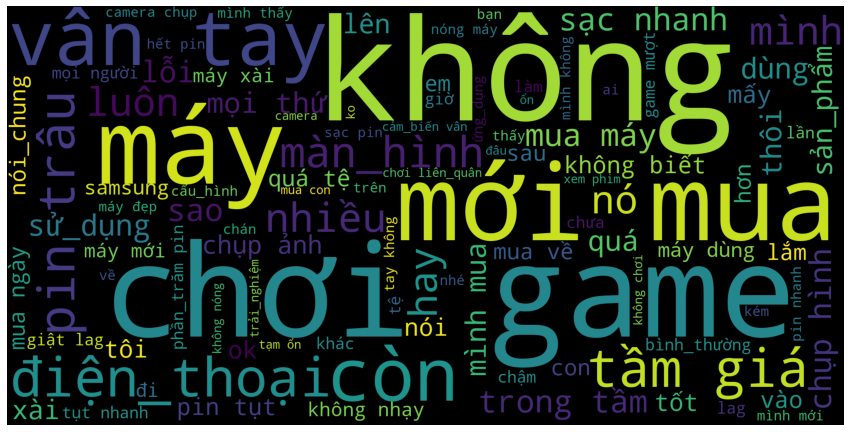

In [ ]:
# create bag-of-words
all_words = []

for token in hl_tokens:
    for w in token:
          all_words.append(w)

corpus=' '.join(all_words)
all_words = nltk.FreqDist(all_words)

# print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))


import wordcloud
import matplotlib.pyplot as plt
%matplotlib inline
#cloud = np.array(all_words).flatten()
plt.figure(figsize=(15,10))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(corpus)
plt.axis("off")
plt.imshow(word_cloud)

### **Data Vectorization**

In [ ]:
max_features = 3000
max_token = len(max(hl_tokens,key=len))
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(hl_tokens)
sequences = tokenizer.texts_to_sequences(hl_tokens)
X = pad_sequences(sequences, maxlen=max_token)

# View comparison
index=0
print('Original texts :')
print(df['CONTENT'][index])
print('\nAfter vectorization :')
print(X[index])

Original texts :
Đt bắt wfi vs 4g yếu quá, cảm ứng nhiều lúc k nhận vân tay thua con dt j4 của mình mới mua băt sống khoẻ hơn a50

After vectorization :
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

# **Training with RNN**

## **Building the Model**

In [ ]:
Y=df['LABEL'].values
Y = np.vstack(Y)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3, random_state = 42)

In [ ]:
clear_session()

In [ ]:
embed_dim = 64
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = max_token))
model.add(LSTM(96, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
model.add(Dense(150))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer=Adam(1e-4),metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 455, 64)           192000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 96)                61824     
_________________________________________________________________
dense_1 (Dense)              (None, 150)               14550     
_________________________________________________________________
batch_normalization_1 (Batch (None, 150)               600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                

## **Training process**

In [ ]:
# simple early stopping
#es = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')


In [ ]:
epoch = 10
batch_size = 32
history=model.fit(X_train, Y_train, epochs = epoch, batch_size=batch_size, verbose = 2, validation_split=0.1)

Train on 9490 samples, validate on 1055 samples
Epoch 1/10
 - 157s - loss: 0.6470 - acc: 0.6244 - val_loss: 0.5800 - val_acc: 0.6967
Epoch 2/10
 - 155s - loss: 0.5084 - acc: 0.7523 - val_loss: 0.4653 - val_acc: 0.7754
Epoch 3/10
 - 155s - loss: 0.4404 - acc: 0.7958 - val_loss: 0.4402 - val_acc: 0.7981
Epoch 4/10
 - 156s - loss: 0.3994 - acc: 0.8217 - val_loss: 0.4034 - val_acc: 0.8294
Epoch 5/10
 - 159s - loss: 0.3760 - acc: 0.8348 - val_loss: 0.3978 - val_acc: 0.8303
Epoch 6/10
 - 166s - loss: 0.3509 - acc: 0.8491 - val_loss: 0.3881 - val_acc: 0.8379
Epoch 7/10
 - 167s - loss: 0.3377 - acc: 0.8568 - val_loss: 0.3930 - val_acc: 0.8408
Epoch 8/10
 - 161s - loss: 0.3230 - acc: 0.8659 - val_loss: 0.4053 - val_acc: 0.8246
Epoch 9/10
 - 158s - loss: 0.3057 - acc: 0.8736 - val_loss: 0.3929 - val_acc: 0.8464
Epoch 10/10
 - 155s - loss: 0.2952 - acc: 0.8774 - val_loss: 0.3974 - val_acc: 0.8474


# ***Model Evaluation***



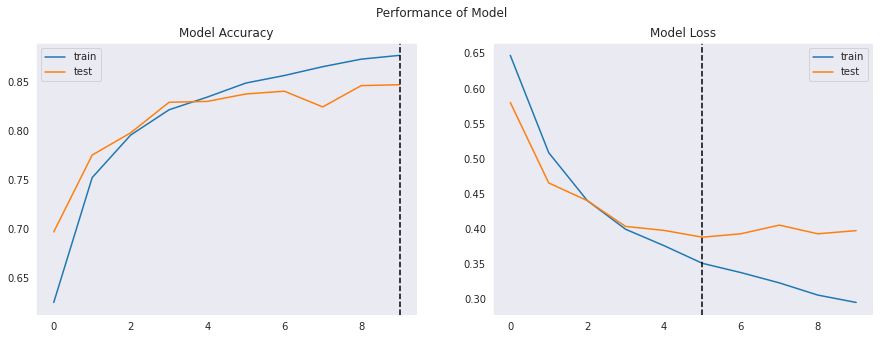

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Model")
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
vline_cut = np.where(history.history['val_acc'] == np.max(history.history['val_acc']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

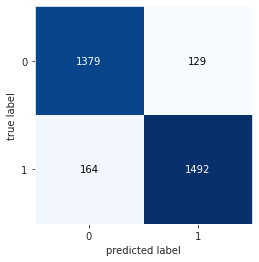

In [ ]:
pred=np.around(model.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Y_test,pred))
plt.show()

In [ ]:
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1508
           1       0.92      0.90      0.91      1656

    accuracy                           0.91      3164
   macro avg       0.91      0.91      0.91      3164
weighted avg       0.91      0.91      0.91      3164



# ***Use Another ML Algorithms to Training***

**Convert Data**

In [ ]:
X = [" ".join(x) for x in hl_tokens]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X,df['LABEL'],test_size=0.3)

**Word Vectorization using TF-IDF**

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=3000)
Tfidf_vect.fit(Train_X)
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [ ]:
print(Tfidf_vect.vocabulary_)

{'mới': 1567, 'đầu': 2886, 'sử_dụng': 2110, 'thi': 2159, 'ổn': 2991, 'sau': 2025, 'cảm_ứng': 669, 'chạm': 526, 'giật': 904, 'lag': 1265, 'treo': 2333, 'máy_thường_xuyên': 1498, 'gọi': 947, 'zalo': 2759, 'ma': 1416, 'máy': 1495, 'nghĩ': 1604, 'chán': 490, 'dùng': 770, 'không': 1193, 'bằng': 396, 'live': 1285, 'nhu': 1672, 'ngày': 1627, 'rơi': 1991, 'vỡ': 2667, 'chơi': 522, 'game': 856, 'điện_thoại': 2820, 'đánh_giá': 2843, '1star': 51, 'đúng': 2865, 'hàng': 1024, 'cao_cấp': 441, 'xài': 2716, 'quá': 1927, 'tuyệt_vời': 2418, 'cầm': 678, 'trong': 2336, 'tay': 2125, 'thấy': 2234, 'sang_trọng': 2022, 'nó': 1764, 'thiết_kế': 2165, 'sang': 2021, 'vào': 2613, 'ứng_dụng': 2999, 'mượt': 1523, 'nhỏ': 1728, 'gọn': 949, 'dễ': 787, 'bỏ_túi': 409, 'mình': 1509, 'mua': 1475, 'thật_sự': 2240, 'hài_lòng': 1022, 'tầm': 2503, 'giá': 886, 'đáng': 2839, 'xem_xét': 2694, 'ip': 1116, 'thích': 2206, 'hơn': 1051, 'nhiều': 1664, 'triệu': 2334, 'còn': 629, 'giảm': 901, '500k': 160, 'trước': 2371, 'sản_phẩm': 2088,

## **Trainning on the SVM classifier**

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear', verbose=True)
SVM.fit(Train_X_Tfidf,Train_Y)

[LibSVM]

SVC(kernel='linear', verbose=True)

**Predict and evaluate the SVM classifier**

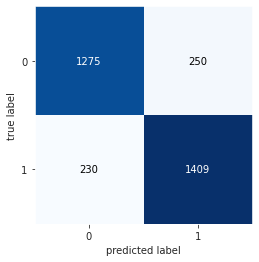

In [ ]:
predictions_SVM=SVM.predict(Test_X_Tfidf)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Test_Y,predictions_SVM))
plt.show()

In [ ]:
print(classification_report(Test_Y,predictions_SVM))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1525
           1       0.85      0.86      0.85      1639

    accuracy                           0.85      3164
   macro avg       0.85      0.85      0.85      3164
weighted avg       0.85      0.85      0.85      3164



## **Trainning on the Naive Bayes Classifier**

In [ ]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

MultinomialNB()

**Predict and evaluate the Naive Bayes Classifier**

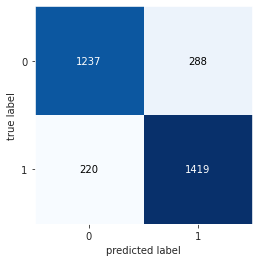

In [ ]:
predictions_NB=Naive.predict(Test_X_Tfidf)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Test_Y,predictions_NB))
plt.show()

In [ ]:
print(classification_report(Test_Y,predictions_NB))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1525
           1       0.83      0.87      0.85      1639

    accuracy                           0.84      3164
   macro avg       0.84      0.84      0.84      3164
weighted avg       0.84      0.84      0.84      3164



# ***Save model***

In [ ]:
joblib.dump(Tfidf_vect, '/content/Sentiment_Classification/model/tfidf.pkl')
joblib.dump(tokenizer, '/content/Sentiment_Classification/model/tokenizer_LSTM.pkl')
joblib.dump(model, '/content/Sentiment_Classification/model/LSTM_model.pkl')
joblib.dump(SVM, '/content/Sentiment_Classification/model/SVM_model.pkl')
joblib.dump(Naive, '/content/Sentiment_Classification/model/NB_model.pkl')
joblib.dump(Tfidf_vect.vocabulary_, '/content/Sentiment_Classification/model/vocabulary.pkl')
joblib.dump(max_token, '/content/Sentiment_Classification/model/max_token.pkl')

['/content/Sentiment_Classification/model/max_token.pkl']

# ***Enter comment and test***

## *utils*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s /content/drive/'My Drive'/Sentiment_Classification

In [ ]:
!pip install underthesea
!pip install unidecode
!pip install scikit-learn==0.23.1
!pip install keras==2.2.5
!pip install TensorFlow==1.14

In [ ]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from underthesea import word_tokenize
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import unidecode
import re
import joblib


path='/content/Sentiment_Classification/'
stopwords=set(open(path+'data/stopwords.txt').read().split(' ')[:-1])

max_token=joblib.load(path+'model/max_token.pkl')
RNN_model=joblib.load(path+'model/LSTM_model.pkl')
RNN_embedding=joblib.load(path+'model/tokenizer_LSTM.pkl')
SVM_model=joblib.load(path+'model/SVM_model.pkl')
NB_model=joblib.load(path+'model/NB_model.pkl')
TFIDF_embedding=joblib.load(path+'model/tfidf.pkl')


def vi_tokenizer(row):
  row=row.lower()
  return word_tokenize(row, format="text")

def remove_accents(row):
  return unidecode.unidecode(row)

def remove_stopwords(hl_split):
  sent = [s for s in hl_split if s not in stopwords]
  return sent

def text_cleasing(row):
  row = row.translate(str.maketrans('', '', punctuation))
  row = row.strip()
  row=vi_tokenizer(row)
  row=remove_stopwords(row.split())
  #row=[remove_accents(s) for s in row]
  #row=[" ".join(x) for x in row]
  return row

def input_vectorization(input_token,w_embedding):
  arr_token=[]
  arr_token.append(input_token)
  sequences = w_embedding.texts_to_sequences(arr_token)
  X = pad_sequences(sequences, maxlen=max_token)
  return X
       

def LSTM_predict(text,model,w_embedding):
  token=text_cleasing(text)
  X=input_vectorization(token,w_embedding)
  if np.around(model.predict(X))==1:
    print(text)
    print("=============> Positive\n")
  else:
    print(text)
    print("=============> Negative\n")

def predict(text,model,w_embedding):
  token=text_cleasing(text)
  token=[' '.join(token)]
  X_Tfidf = w_embedding.transform(token)
  if model.predict(X_Tfidf)[0]==1:
    print(text)
    print("=============> Positive\n")
  else:
    print(text)
    print("=============> Negative\n")

def standardize_data(df):
    hl_cleansed=[]
    for row in df:
        row = row.translate(str.maketrans('', '', punctuation))
        row = row.strip()
        hl_cleansed.append(row)
    return hl_cleansed


def multi_predict(list_data,choice):
  result=dict()
  hl_cleansed=standardize_data(list_data)
  rs=[]
  num_positive=None
  num_negative=None
  hl_tokens = []
  for hl in hl_cleansed:
      hl=vi_tokenizer(hl)
      clean=remove_stopwords(hl.split())
      #clean=[remove_accents(s) for s in clean]
      hl_tokens.append(clean)

  #choice == RNN using RNN model
  if choice=='RNN':
    sequences = RNN_embedding.texts_to_sequences(hl_tokens)
    X = pad_sequences(sequences, maxlen=max_token)
    rs=np.around(RNN_model.predict(X))

    
  #choice ==SVM using SVM classifer
  elif choice=='SVM':
    X = [" ".join(x) for x in hl_tokens]
    X = TFIDF_embedding.transform(X)
    rs = SVM_model.predict(X)
  

  elif choice=='NB':
    X = [" ".join(x) for x in hl_tokens]
    X = TFIDF_embedding.transform(X)
    rs = NB_model.predict(X)
    

  num_positive=np.count_nonzero(rs == 1)
  num_negative=np.count_nonzero(rs == 0)
  rs=rs.flatten().astype(int)
  
  percentage_of_positive= round(num_positive/(num_positive + num_negative)*100,2)
  index_of_positive=[i for i, e in enumerate(rs) if e == 1]
  index_of_negative=[i for i, e in enumerate(rs) if e == 0]
  recommend='Máy được khen trên '+str(percentage_of_positive)+'%, mua đi !!' if percentage_of_positive > 65 \
                            else 'Máy bị chê quá nhiều ('+str(100-percentage_of_positive)+'%), không nên mua'

  result['Number of positive']=num_positive
  result['Number of negative']=num_negative
  result['Recommend']=recommend
  result['Index of positive']= index_of_positive
  result['Index of negative']= index_of_negative
  result['Model']= choice


  return result

  


In [ ]:
cmt0='máy bắt wifi như lolllllllllllll'

cmt1='Quá buồn khi mua em này, loa cuộc gọi siêu bé, không nghe được, vân tay không nhạy 1 tí gì. Mình mua được 2 tuần. Giờ mình phải làm sao????'

cmt2='ngon quá, sẽ ủng hộ shop dài dài.'

cmt3='Quá tuyệt, siêu phẩm 2020 là đây, giá rẻ mà cấu hình lại cao nữa.'

cmt4='Rất buồn,máy ok đó nhưng TGDĐ làm ăn bảo hành như cc, mang ra đổi trả không chịu !!!'

cmt5='Đã thử sang note 10 nhưng vẫn quay lại với IPhone. Thề androi như bùi mng ạ.. phần gia công iphone làm rất tốt. Cái note 10+ thật sự đc mỗi cái màn hình ngon'

cmt6='Máy thì ngon nhưng chủ yếu dùng nghe gọi nên giá hơi chát. Tuy nhiên iphone dùng 4,5 năm vẫn tốt. Nên mua.'

cmt7="Mình mua được hơn 1 tháng rồi máy hoạt động êm nước lọc ngon nhưng không được hài lòng cho lắm"

cmt=[cmt0,cmt1,cmt2,cmt3,cmt4,cmt5,cmt6,cmt7]

In [ ]:
a=multi_predict(cmt,'RNN')
a

{'Index of negative': [0, 1, 4, 5],
 'Index of positive': [2, 3, 6, 7],
 'Model': 'RNN',
 'Number of negative': 4,
 'Number of positive': 4,
 'Recommend': 'Máy bị chê quá nhiều (50.0%), không nên mua'}

## Predict

Using LSTM model to predict

In [ ]:
cmt='máy bắt wifi như lolllllllllllll'

cmt2='Quá buồn khi mua em này, loa cuộc gọi siêu bé, không nghe được, vân tay không nhạy 1 tí gì. Mình mua được 2 tuần. Giờ mình phải làm sao????'

cmt3='ngon quá, sẽ ủng hộ shop dài dài'



LSTM_predict(cmt,RNN_model,RNN_embedding)
LSTM_predict(cmt2,RNN_model,RNN_embedding)
LSTM_predict(cmt3,RNN_model,RNN_embedding)



máy bắt wifi như lolllllllllllll
=============> Negative

Quá buồn khi mua em này, loa cuộc gọi siêu bé, không nghe được, vân tay không nhạy 1 tí gì. Mình mua được 2 tuần. Giờ mình phải làm sao????
=============> Negative

ngon quá, sẽ ủng hộ shop dài dài
=============> Positive



Using SVM clasifier

In [ ]:
predict(cmt,SVM_model,TFIDF_embedding)
predict(cmt2,SVM_model,TFIDF_embedding)
predict(cmt3,SVM_model,TFIDF_embedding)

máy bắt wifi như lolllllllllllll
=============> Negative

Quá buồn khi mua em này, loa cuộc gọi siêu bé, không nghe được, vân tay không nhạy 1 tí gì. Mình mua được 2 tuần. Giờ mình phải làm sao????
=============> Negative

ngon quá, sẽ ủng hộ shop dài dài
=============> Positive



Using NB clasifier


In [ ]:
predict(cmt,NB_model,TFIDF_embedding)
predict(cmt2,NB_model,TFIDF_embedding)
predict(cmt3,NB_model,TFIDF_embedding)

máy bắt wifi như lolllllllllllll
=============> Negative

Quá buồn khi mua em này, loa cuộc gọi siêu bé, không nghe được, vân tay không nhạy 1 tí gì. Mình mua được 2 tuần. Giờ mình phải làm sao????
=============> Negative

ngon quá, sẽ ủng hộ shop dài dài
=============> Positive

